# Generating data for volatility surfaces: rBergomi

text goes here...

## 0. Imports

In [1]:
import gzip

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from src.utils.helper_functions.global_helper_functions import get_project_root

## 1. Functions for learning map $\Theta \to \mathbb{R}^{T \times K}$

In [2]:
def cust_scaler(x: np.ndarray, ub: np.ndarray, lb: np.ndarray) -> np.ndarray:
    """
    Scales inputs data with a custom upper and lower bound requirement (min-max scaling).

    :param x:   Inputs
    :param ub:  Vector of upper bounds, needs to have same number of components as x
    :param lb:  Vector of lower bounds, needs to have same number of components as x
    :return:    Scaled data
    """
    return (x - (ub + lb)*0.5) * 2 / (ub - lb)


def inv_cust_scaler(x: np.ndarray, ub: np.ndarray, lb: np.ndarray) -> np.ndarray:
    """
    Same as the above function, but performs the inverse transform

    :param x:   Data to inverse scale
    :param ub:  Upper bounds, same length as x data
    :param lb:  Lower bounds, same length as x data
    :return:    Inverse transformed data
    """
    return x*(ub - lb)*0.5 + (ub + lb)*0.5


class FeedforwardNetwork(torch.nn.Module):
    """
    Standard multi-layer perceptron
    """
    def __init__(self, in_size: int, out_size: int, mlp_size: int = 32, num_layers: int = 3, activation: str = "ReLU",
                 final_activation: str = "Identity", device: str = "cpu"):
        """
        Initialisation of perceptron

        :param in_size:          Size of data input
        :param out_size:         Output data size
        :param mlp_size:         Number of neurons in each hidden layer
        :param num_layers:       Number of hidden layers
        :param activation:       Activation functions to use
        :param final_activation: Activation to use on the final layer
        :param device:           GPU implementation if cuda is available
        """
        super().__init__()

        activation_fn = getattr(torch.nn, activation)()
        final_activation_fn = getattr(torch.nn, final_activation)()

        model = [torch.nn.Linear(in_size, mlp_size),
                 activation_fn]
        for _ in range(num_layers - 1):
            model.append(torch.nn.Linear(mlp_size, mlp_size))
            model.append(activation_fn)
        model.append(torch.nn.Linear(mlp_size, out_size))
        model.append(final_activation_fn)
        self._model = torch.nn.Sequential(*model)

        self.trange = None
        self.device = device

    def forward(self, x):
        if type(x) != torch.Tensor:
            x = torch.tensor(x, dtype=torch.float).to(self.device)
        return self._model(x)

    def fit(self, X_train, X_test, y_train, y_test, loss_function: str = "MSELoss", optimiser: str = "Adam",
            epochs: int = 20, batch_size: int = 32, learning_rate: float = 1e-2, weight_decay: float = 0.01,
            pct_print: float = 0.25, writer = tqdm):
        """
        Fits the model with the following parameter combinations

        :param X_train:         Train feature set
        :param X_test:          Test feature set
        :param y_train:         Train label set
        :param y_test:          Test label set
        :param loss_function:    Loss function to use in training
        :param optimiser:        Optimiser to use in training
        :param epochs:           Number of epochs to train network for
        :param batch_size:       Size of mini-batches used in training
        :param learning_rate:    Learning rate used in optimisation
        :param weight_decay:     Rate of weight decay during learning
        :param pct_print:        Percentage of each epoch to print results
        :param writer:           TQDM writer to use
        :return:
        """

        train_loss = []

        if loss_function == "RMSELoss":
            criterion = torch.nn.MSELoss()

            def _loss(x, y):
                return torch.sqrt(criterion(x, y))
        else:
            criterion = getattr(torch.nn, loss_function)()

            def _loss(x, y):
                return criterion(x, y)

        _optimiser    = getattr(torch.optim, optimiser)(self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        if not type(X_train) == torch.Tensor:
            X_train = torch.tensor(X_train, dtype=torch.float).to(self.device)
            X_test  = torch.tensor(X_test, dtype=torch.float).to(self.device)
            y_train = torch.tensor(y_train, dtype=torch.float).to(self.device)
            y_test  = torch.tensor(y_test, dtype=torch.float).to(self.device)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)
        test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

        display_steps = torch.round(
            torch.tensor([pct_print*i*int(len(train_loader.dataset)/batch_size) for i in range(int(1/pct_print + 1))])
        ).int()

        self.trange = writer(range(epochs), position=0, leave=True)

        self.test(test_loader, criterion)
        for step in self.trange:
            for batch_idx, (data, target) in enumerate(train_loader):
                inputs, labels = data, target

                _optimiser.zero_grad()

                outputs = self(inputs)
                # loss = criterion(outputs, target)
                loss = _loss(outputs, target)
                loss.backward()
                _optimiser.step()

                train_loss.append(loss.item())

                if batch_idx in display_steps:
                    if batch_idx == 0:
                        self.trange.write('\nTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6e}'.format(
                            step + 1, batch_idx * len(data), len(train_loader.dataset),
                            100. * batch_idx / len(train_loader), loss.item()))
                    else:
                        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6e}'.format(
                            step + 1, batch_idx * len(data), len(train_loader.dataset),
                            100. * batch_idx / len(train_loader), loss.item()))

            self.test(test_loader, criterion)

        return train_loss

    def test(self, loader, criterion):
        self.eval()

        test_loss = 0

        for data, target in loader:
            output = self(data)
            test_loss += criterion(output, target).item()

        test_loss /= len(loader.dataset)

        self.trange.write('\nTest set: Avg. loss: {:.4f}'.format(test_loss))

In [3]:
data_root = get_project_root().as_posix() + "/data"
train_model = False

# 1. Load data
f   = gzip.GzipFile(data_root + "/rBergomiTrainSet.txt.gz", "r")
data = np.load(f)

y = data[:, 4:]
X = data[:, :4]

strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

train_test_split_pct = 0.85
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_split_pct, random_state=42)

In [4]:
# 2. Scale input and output data
y_scaler = StandardScaler()
y_train_transformed = y_scaler.fit_transform(y_train)
y_test_transformed  = y_scaler.transform(y_test)

ub = np.array([0.16, 4, -0.1, 0.5])
lb = np.array([0.01, 0.3, -0.95, 0.025])

X_train_transformed = np.array([cust_scaler(xi, ub, lb) for xi in X_train])
X_test_transformed  = np.array([cust_scaler(xi, ub, lb) for xi in X_test])

## 2. Build and train Neural Net $f_\theta: \Theta \to \mathbb{R}^{T \times K}$

In [5]:
# 3. Build and train neural network
in_size = X_train.shape[-1]
out_size = y_train.shape[-1]

device = "cuda" if torch.cuda.is_available() else "cpu"

ffn = FeedforwardNetwork(
    in_size          = in_size,
    out_size         = out_size,
    mlp_size         = 32,
    num_layers       = 3,
    activation       = "ELU",
    final_activation = "Identity",
    device           = device
).to(device)

if train_model:
    _ = ffn.fit(
        X_train=X_train_transformed,
        X_test=X_test_transformed,
        y_train=y_train_transformed,
        y_test=y_test_transformed,
        loss_function="RMSELoss",
        optimiser="Adam",
        epochs=20,
        batch_size=64,
        learning_rate=1e-2,
        weight_decay=0.0,
        pct_print=0.25,
    )

    torch.save(ffn.state_dict(), get_project_root().as_posix() + "/saved_models/rBergomi_DLV/ffn.pkl")
else:
    ffn_state_dict = torch.load(get_project_root().as_posix() + "/saved_models/rBergomi_DLV/ffn.pkl")
    ffn.load_state_dict(ffn_state_dict)

## 3. Display results

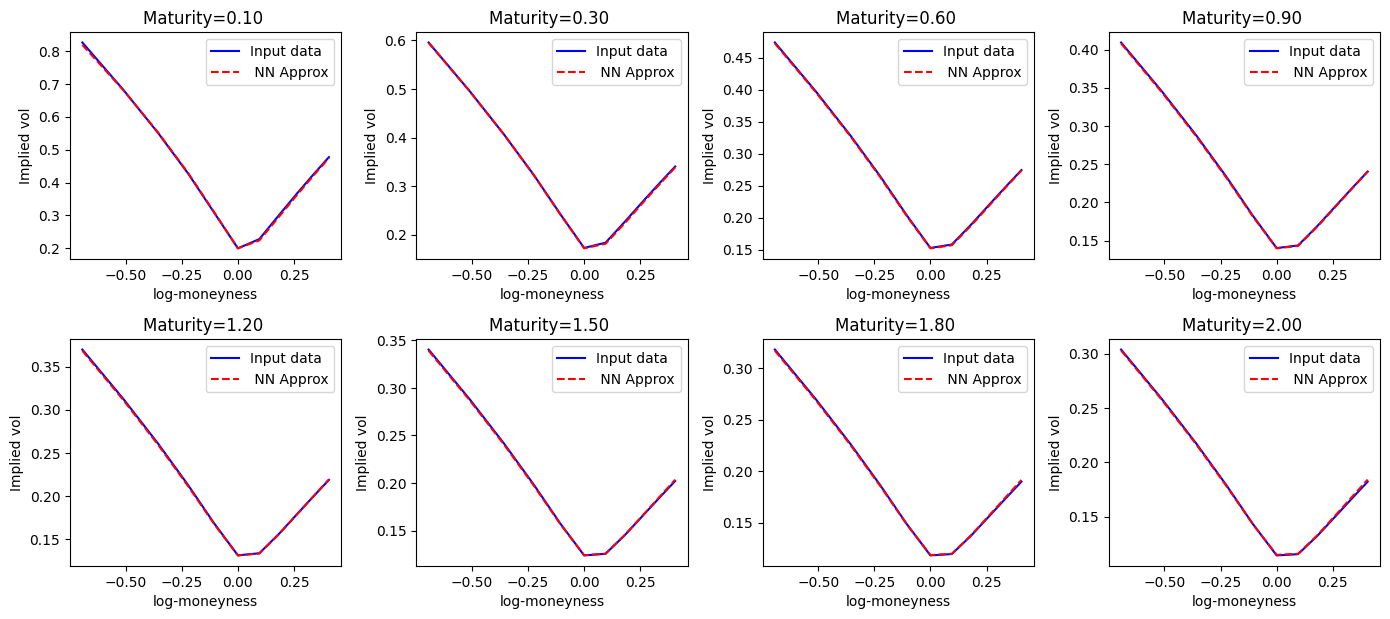

In [6]:
# 4. Plot sample smiles to verify results
sample_ind = 125

target     = y_test[sample_ind]
raw_output = ffn(X_test_transformed[sample_ind]).detach().cpu().numpy()
output     = y_scaler.inverse_transform(raw_output.reshape(1, -1))[0]

maturities_dim = len(maturities)
strikes_dim    = len(strikes)
S0             = 1.

plt.figure(1, figsize=(14, 12))
for i in range(maturities_dim):
    plt.subplot(4, 4, i + 1)

    plt.plot(np.log(strikes / S0), target[i * strikes_dim:(i + 1) * strikes_dim], 'b', label="Input data")
    plt.plot(np.log(strikes / S0), output[i * strikes_dim:(i + 1) * strikes_dim], '--r', label=" NN Approx")

    plt.title("Maturity=%1.2f " % maturities[i])
    plt.xlabel("log-moneyness")
    plt.ylabel("Implied vol")

    plt.legend()
plt.tight_layout()
plt.show()

## 4. OU SDE for simulating time-evolved parameters of rBergomi model

In [7]:
# 5. Select random points from train/test set as baselines for building tensors
import torch
import torchsde

class OrnsteinUhlenbeckProcess(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"
    def __init__(self, theta, mu, sigma, d):
        """
        Initialize the multivariate Ornstein-Uhlenbeck process.
        
        Parameters:
        - theta (float): Rate of mean reversion.
        - mu (float): Long-term mean.
        - sigma (float): Volatility parameter.
        - d (int): Dimension of the process (number of variables).
        """
        super().__init__()
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.d = d
    
    def f(self, t, y):
        """Drift term of the SDE."""
        return self.theta * (self.mu - y)
    
    def g(self, t, y):
        """Diffusion term of the SDE"""
        return self.sigma * torch.full_like(y, fill_value=1.)

In [8]:
# Just take all the sample points we have
X_transformed = np.concatenate([X_train, X_test], axis=0)

# For each point, simulate parameter evolutions over a specified grid
grid_points = 32
ts = torch.linspace(0, 1, grid_points).to(device)

# Set to torch
X_transformed_t = torch.tensor(X_transformed, dtype=torch.float32).to(device)

# Get bounds
ubs = X_transformed_t.max(axis=0).values
lbs = X_transformed_t.min(axis=0).values

In [9]:
theta = 0.7
mu    = X_transformed_t.mean(axis=0)
sigma = X_transformed_t.std(axis=0)
d     = X_transformed_t.shape[-1]
ou_process = OrnsteinUhlenbeckProcess(theta, mu, sigma, d)

## 5. Time-evolve parameters and map $f_\theta$ over time-evolved sequence

In [10]:
with torch.no_grad():
    X_evolved = torchsde.sdeint(ou_process, X_transformed_t, ts, method="euler").transpose(1, 0)

In [11]:
# Re-transform
def custom_min_max_scaling(X, lbs, ubs):
    # Reshape lbs and ubs for broadcasting, adding dimensions for N and n_t
    lbs = lbs.view(1, 1, -1)
    ubs = ubs.view(1, 1, -1)
    
    # Calculate min and max across N and n_t for each feature
    X_min = X.min(dim=0)[0].min(dim=0)[0]  # Min across N and n_t
    X_max = X.max(dim=0)[0].max(dim=0)[0]  # Max across N and n_t
    
    # Ensure the shape matches for broadcasting
    X_min = X_min.view(1, 1, -1)
    X_max = X_max.view(1, 1, -1)
    
    # Apply the min-max scaling formula
    scaled_X = lbs + (X - X_min) * (ubs - lbs) / (X_max - X_min)
    
    return scaled_X

In [12]:
X_evolved = custom_min_max_scaling(X_evolved, lbs, ubs)

In [13]:
# Get evolved surfaces
N, l, T, K     = X_evolved.shape[0], grid_points, len(maturities), len(strikes)
X_surf_evolved = torch.zeros((N, l, T, K), dtype=torch.float32).to(device)

In [14]:
# Map FFN over each point, inverse transform
do_inverse = True

with torch.no_grad():
    for idx, batch in enumerate(tqdm(X_evolved, position=0)):
        surf_ = ffn(batch).cpu()
        
        if do_inverse:
            these_surfaces = y_scaler.inverse_transform(surf_)
        else:
            these_surfaces = surf_
            
        X_surf_evolved[idx] = torch.tensor(these_surfaces).reshape(l, T, K)

100%|██████████| 40000/40000 [00:59<00:00, 673.70it/s]


## 6. Plot results, save down file as .npy

In [15]:
# Plot an example: surface, and slice
from mpl_toolkits.mplot3d import Axes3D


def plot_time_evolved_surface(x, y, Z, times, elev=30, azim=45):
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(14, 6))

    for i, time in enumerate(times):        
        ax = fig.add_subplot(1, len(times), i+1, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        ax.plot_surface(X, Y, Z[i], cmap='viridis')
        ax.set_title(f'Time = {time:.4f}')
        ax.set_xlabel('$\log{K/S_0}$')
        ax.set_ylabel('$T$')
        ax.set_zlabel('$\sigma_I$')
    
    plt.tight_layout()
    plt.show()
    
    
def plot_time_evolved_slice(x, y, Z, time):
    X, Y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(f'Surface slice, strike = {time:.4f}')
    ax.set_xlabel('$\log{K/S_0}$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$\sigma_I$')
    plt.tight_layout()
    plt.show()

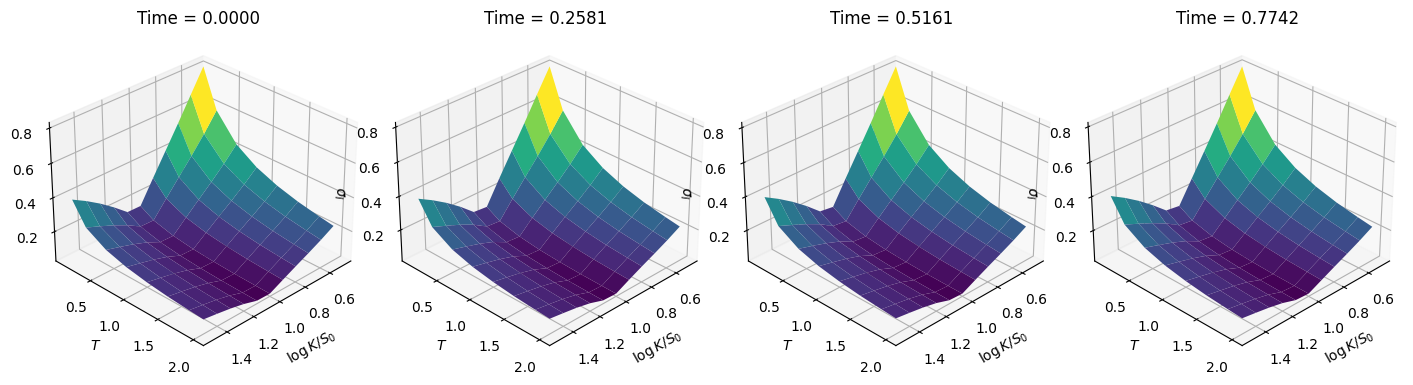

In [16]:
with torch.no_grad():
    plot_ts = ts.cpu().numpy()
        
    test_surface = X_surf_evolved[0].cpu().numpy()
    plot_time_evolved_surface(strikes, maturities, test_surface[::8], plot_ts[::8])

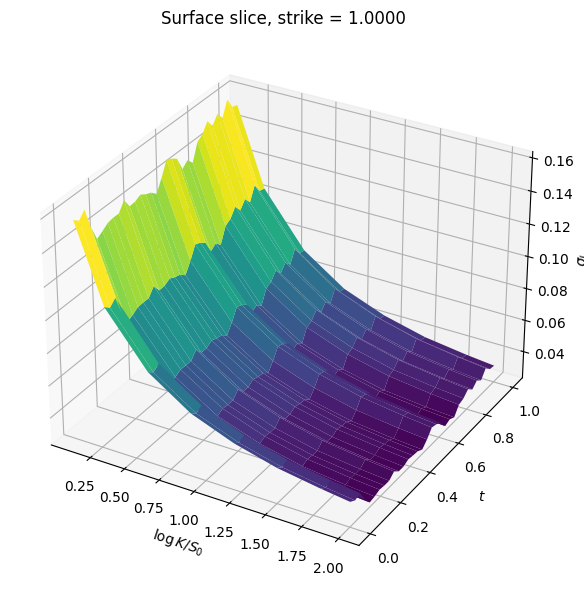

In [17]:
with torch.no_grad():
    atm_ind = 5
    plot_ts = ts.cpu()
    plot_time_evolved_slice(maturities, plot_ts, test_surface[..., atm_ind], strikes[atm_ind])

In [18]:
# Save down
with torch.no_grad():
    torch.save(X_surf_evolved, data_root + "/rBergomi_vol_surfaces.pt")